In [1]:
import pandas as pd
import numpy as np
from bcb import sgs
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from scipy.optimize import curve_fit
from sklearn import linear_model

In [2]:
def absolute(serie):
    valor_atual = 1598.41
    yield valor_atual
    for valor in serie[1:]:
        valor = valor / 100
        valor_atual += (valor_atual * valor)
        yield valor_atual

def months_until_next_election(date_serie):
    for date in date_serie:
        year = date.year
        years_until_next_election = abs(((year - 2) % 4) - 4)
        if years_until_next_election == 4:
            if date <= pd.to_datetime(f'{year}-10-01'):
                years_until_next_election = 0
        days_until_october = (pd.to_datetime(f'{year}-10-01') - date).days
        yield int((days_until_october + (365 * years_until_next_election)) / 30.5)

def get_indicators(start_date):
    dados = {'celic':432,'emprego':28763,'producao':21859,'comercio':1455,'energia':1406,'IPCA_change':433}
    dataframe = sgs.get(dados,start = start_date)
    dataframe = dataframe.fillna(method = 'bfill')
    dataframe = dataframe.resample('m').mean()
    dataframe['IPCA'] = [valor for valor in absolute(dataframe['IPCA_change'].values)]
    del(dataframe['IPCA_change'])
    dataframe = dataframe.dropna()
    return dataframe

<AxesSubplot:xlabel='Date'>

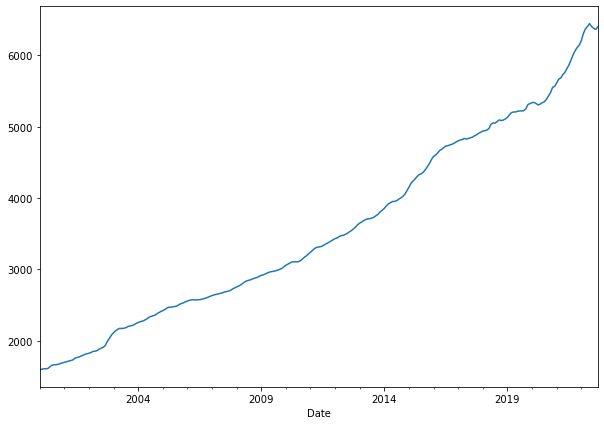

In [3]:
df = get_indicators('2000-01-01')
ipca = df[['IPCA']].copy()
ipca = ipca.rename({'IPCA':'indice'},axis = 1)
df = df.drop(['IPCA'],axis = 1)
ipca.indice.plot(figsize = (10, 7))

In [41]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA
from pyGRNN import GRNN

In [42]:
def square(x,a,b,c):
    return ((x ** 2) * a) + (x * b) + c

def linear(x,a,b):
    return (x * a) + b

def untrend(serie):
    data = pd.DataFrame({'y':serie})
    x_values = np.arange(len(serie))
    popt = curve_fit(square,x_values,serie)[0]
    data['trend'] = [square(x,*popt) for x in x_values]
    data['no_trend'] = data['y'] - data['trend']
    return data['no_trend'].values

def train_test_split(xdata,ydata,horizonte):
    meses = horizonte * 12
    y_train,y_test = ydata.values[:-meses],ydata.values[-meses:]
    x_train,x_test = xdata.values[-meses - len(y_train):-meses],xdata.values[-meses:]
    return x_train,y_train.ravel(),x_test,y_test.ravel()

class base_model:
    def __init__(self,data,func):
        self.data = data
        self.func = func
    def fit(self):
        y = self.data
        self.popt = curve_fit(self.func,list(range(len(y))),y)[0]
        self.x0 = len(y)
        self.last_y = y[-1]
        return self
    def predict(self,n):
        prediction = np.array([self.func(x,*self.popt) for x in range(self.x0,self.x0 + n)])
        diferenca = prediction[0] - self.last_y
        return prediction - diferenca

class modelo:
    def __init__(self,name,ydata,xdata = None):
        self.name = name
        if name == 'holt':
            self.model = ExponentialSmoothing(ydata,seasonal_periods = 12,trend = "add",seasonal = "add").fit(0,0,0)
        if name == 'arima':
            self.model = AutoARIMA(sp = 12,suppress_warnings = True).fit(ydata)
        if self.name == 'grnn':
            self.model = GRNN().fit(xdata,ydata)

    def predict(self,n = None,data = None):
        if self.name == 'holt':
            return self.model.forecast(n)
        if self.name == 'arima':
            return self.model.predict(fh = list(range(1,n + 1))).ravel()
        if self.name == 'grnn':
            return self.model.predict(data)

class GodModel:
    def __init__(self,func,modelo,peso = 0.5):
        self.peso = peso
        self.func = func
        self.name = modelo
    
    def fit(self,target_data,extra_data,time_features = None):
        # Regressão linear das features secundarias
        self.reg = linear_model.LinearRegression()
        self.reg.fit(extra_data,target_data)
        # Regressão polinomial no tempo
        self.x0 = len(target_data)
        self.features = range(len(extra_data[0]))
        self.popts = [curve_fit(square,list(range(self.x0)),extra_data[:,i])[0] for i in self.features]
        self.popts_main = curve_fit(self.func,list(range(self.x0)),target_data)[0]
        # Sazonalidade
        untrended = untrend(target_data)
        self.model = modelo(self.name,untrended,time_features)
        self.target_data = target_data
        self.extra_data = extra_data
        return self

    def predict(self,n,time_features = None):
        self.predictions = []
        for i in self.features:
            popt = self.popts[i]
            prediction = np.array([square(x,*popt) for x in range(self.x0,self.x0 + n)])
            partial_last_year_mean = self.extra_data[-12:,i].mean()
            diferenca = partial_last_year_mean - prediction[0]
            prediction = prediction + diferenca
            self.predictions.append(prediction)
        main_prediction = np.array([self.func(x,*self.popts_main) for x in range(self.x0,self.x0 + n)])
        predictores = np.array(self.predictions).T
        feat_prediction = self.reg.predict(predictores)
        trend = (main_prediction * self.peso) + (feat_prediction * (1 - self.peso))
        seasonality = self.model.predict(n,time_features)
        prediction_final = trend + seasonality
        # Ajustes finais
        last_year_mean = self.target_data[-12:].mean()
        diferenca = last_year_mean - prediction_final[0]
        prediction_final = prediction_final + diferenca
        micro_diferenca = self.target_data[-1] - prediction_final[0]
        prediction_final = np.array([prediction_final[i] + (micro_diferenca * (1 - (i / (len(prediction_final) - 1)))) for i in range(len(prediction_final))])
        return prediction_final

MSE: 22617.934668968413
RMSE: 150.3926017760462


<AxesSubplot:xlabel='Date'>

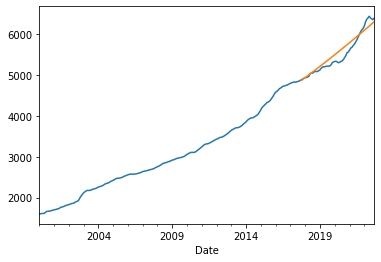

In [43]:
anos = 5
func = square
y_train,y_test = ipca['indice'].iloc[:-anos * 12].values,ipca['indice'].iloc[-anos * 12:].values
model = base_model(y_train,func).fit()
prediction = model.predict(12 * anos)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
pred_df = ipca.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction.ravel())
pred_df['indice'].plot()
pred_df['prediction'].plot()

MSE: 67681.07160490018
RMSE: 260.15586021633294


<AxesSubplot:xlabel='Date'>

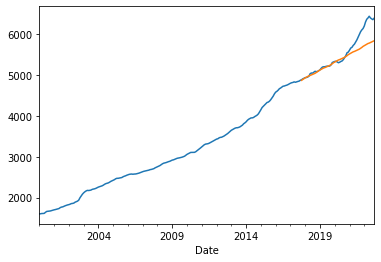

In [49]:
anos = 5
x_train,y_train,x_test,y_test = train_test_split(df,ipca['indice'],anos)
model = GodModel(square,'holt',0).fit(y_train,x_train)
prediction = model.predict(12 * anos)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
pred_df = ipca.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction.ravel())
pred_df['indice'].plot()
pred_df['prediction'].plot()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [6]:
timeseries = TimeSeries.from_dataframe(ipca)
extra_variables = TimeSeries.from_dataframe(df)

In [37]:
scaler_y = Scaler()
scaled_serie = scaler_y.fit_transform(timeseries)
scaler_x = Scaler()
scaled_covariates = scaler_x.fit_transform(extra_variables)

In [40]:
anos = 5
train = scaled_serie[:-12 * anos]
cov_train = scaled_covariates[:-12 * anos]

In [46]:
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12 * anos,
    n_epochs=300,
    random_state=0,
)

In [47]:
model_cov.fit(
    series=train,
    past_covariates=cov_train,
    verbose=True,
)

2022-12-06 17:01:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 130 samples.
2022-12-06 17:01:17 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-12-06 17:01:17 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-12-06 17:01:17 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-12-06 17:01:17 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-12-06 17:01:17 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-12-06 17:01:17 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.3 K 
4 

Epoch 299: 100%|██████████| 5/5 [00:00<00:00, 38.76it/s, loss=6.14e-05, train_loss=5.88e-5] 


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, -7.42it/s]   


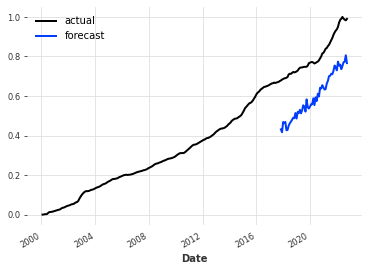

In [48]:
pred_cov = model_cov.predict(n=12 * anos, series=train, past_covariates=cov_train)

scaled_serie.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()